In [1]:
from jax.scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import numpy as np
import optax
from PIL import Image
import jax.numpy as jnp
import jax
from drawingwithgaussians.rendering2d import rasterize, pixel_loss

seed = 0
key = jax.random.key(seed)

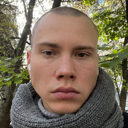

In [2]:
path = '/Users/gleb/Downloads/artem.jpg'
img = Image.open(path).resize((128, 128))
img

In [8]:
height = 128
width = 128
angle = 0.
num_gaussians = 3
lr = 1e-3
max_steps = 500
learning_rate_schedule = optax.constant_schedule(lr) #(lr, max_steps)

target_image = jnp.array(img, dtype=jnp.float32)[:, :, :3] / 255
canvas = jnp.zeros((height, width, 3), dtype=jnp.float32)
means = jax.random.uniform(key, (num_gaussians, 2), minval=0, maxval=height, dtype=jnp.float32)
covariances = jnp.stack([jnp.diag(sigma**2) for sigma in jax.random.uniform(key, (num_gaussians, 2), minval=10, maxval=50, dtype=jnp.float32)])
colors = jnp.clip(jax.random.uniform(key, (num_gaussians, 4)), 0, 1.)
colors = colors.at[:, 3].set(colors[:, 3])
r = R.from_euler('x', [angle,])
rotmats = jnp.repeat(r.as_matrix()[1:, 1:][None], num_gaussians, axis=0)

optimize_means = optax.adam(learning_rate_schedule)
optimize_cov = optax.adam(learning_rate_schedule)
optimize_colors = optax.adam(learning_rate_schedule)
optimize_rotmats = optax.adam(learning_rate_schedule)

opt_state_means = optimize_means.init(means)
opt_state_cov = optimize_cov.init(covariances)
opt_state_colors = optimize_colors.init(colors)
opt_state_rotmats = optimize_rotmats.init(rotmats)

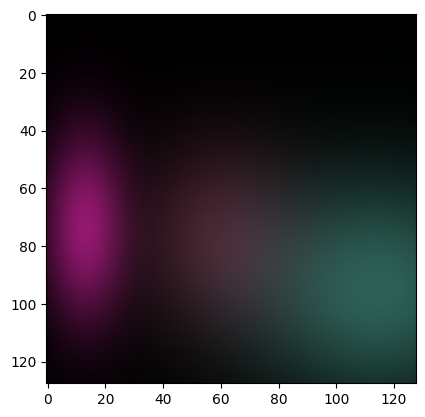

In [9]:
renderred_gaussians, opacity = rasterize(means, covariances, colors, rotmats, height, width)
plt.imshow(jnp.clip(renderred_gaussians, 0, 1))

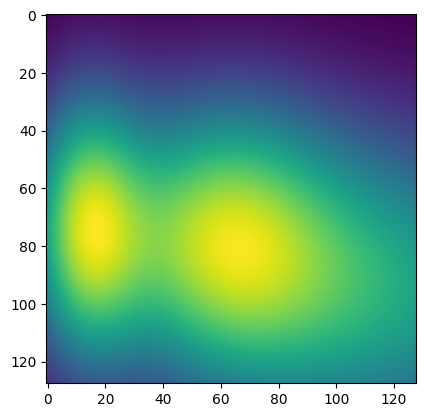

In [10]:
plt.imshow(opacity)

In [6]:
prev_stats = []
for step in range(max_steps):
    loss, gradients = jax.value_and_grad(pixel_loss, argnums=[0, 1, 2, 3])(means, covariances, colors, rotmats, target_image)
    
    updates_means, opt_state_means = optimize_means.update(gradients[0], opt_state_means)
    means = optax.apply_updates(means, updates_means)

    updates_cov, opt_state_cov = optimize_cov.update(gradients[1], opt_state_cov)
    covariances = optax.apply_updates(covariances, updates_cov)

    updates_colors, opt_state_colors = optimize_colors.update(gradients[2], opt_state_colors)
    colors = optax.apply_updates(colors, updates_colors)

    updates_rotmats, opt_state_rotmats = optimize_colors.update(gradients[3], opt_state_rotmats)
    rotmats = optax.apply_updates(rotmats, updates_rotmats)

    if jnp.isnan(loss):
        print(prev_stats)
        print(loss, [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients])
        break
    if step % 50 == 0:
        print(loss, [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients])
    prev_stats = [(jnp.linalg.norm(gradient), gradient.max()) for gradient in gradients]

0.73314595 [(Array(0.00688116, dtype=float32), Array(0.00276194, dtype=float32)), (Array(0.00036887, dtype=float32), Array(0.00018079, dtype=float32)), (Array(0.24148755, dtype=float32), Array(0.12537722, dtype=float32)), (Array(0.23545936, dtype=float32), Array(0.09392983, dtype=float32))]
0.6572715 [(Array(0.006469, dtype=float32), Array(0.00290721, dtype=float32)), (Array(0.00032486, dtype=float32), Array(0.00015895, dtype=float32)), (Array(0.21693997, dtype=float32), Array(0.11360972, dtype=float32)), (Array(0.22395901, dtype=float32), Array(0.08859272, dtype=float32))]
0.5858804 [(Array(0.00589353, dtype=float32), Array(0.00263662, dtype=float32)), (Array(0.00028299, dtype=float32), Array(0.00013867, dtype=float32)), (Array(0.1923346, dtype=float32), Array(0.10156152, dtype=float32)), (Array(0.21516468, dtype=float32), Array(0.08298402, dtype=float32))]
0.5177793 [(Array(0.00527026, dtype=float32), Array(0.00257973, dtype=float32)), (Array(0.00024272, dtype=float32), Array(0.00011

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2, 128, 128) + inhomogeneous part.

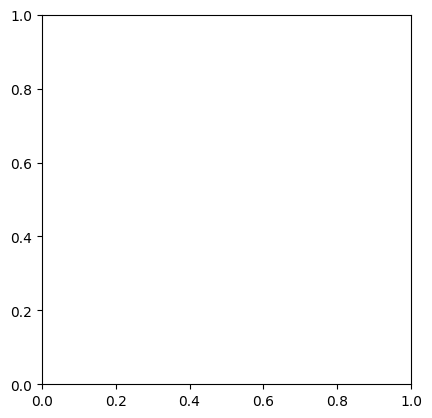

In [7]:
renderred_gaussians = rasterize(means, covariances, jnp.clip(colors, 0, 1), rotmats, height, width)
plt.imshow(renderred_gaussians)